In [ ]:
!pip3 install kaggle

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [ ]:
api = KaggleApi()

In [ ]:
api.competition_download_file('sentiment-analysis-on-movie-reviews',
                              'test.tsv.zip', path='./')
api.competition_download_file('sentiment-analysis-on-movie-reviews',
                              'train.tsv.zip', path='./')

In [ ]:
import zipfile

In [ ]:
with zipfile.ZipFile('./test.tsv.zip', 'r') as zipref:
    zipref.extractall('./')

In [ ]:
with zipfile.ZipFile('./train.tsv.zip', 'r') as zipref:
    zipref.extractall('./')

## Preprocess

In [9]:
import pandas as pd

In [10]:
df = pd.read_csv('train.tsv', sep = "\t")
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [ ]:
df = df.drop(df[df['SentenceId'] > 0].sample(frac=.99).index)

In [ ]:
df.shape

In [ ]:
!pip install matplotlib

In [11]:
import matplotlib

<AxesSubplot:>

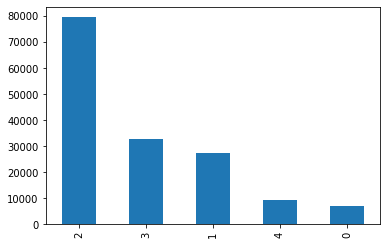

In [12]:
df['Sentiment'].value_counts().plot(kind='bar')

In [13]:
seq_len = 512
num_samples = len(df)

num_samples, seq_len

(156060, 512)

In [ ]:
!pip3 install --upgrade numpy

In [ ]:
import tensorflow as tf

In [ ]:
from transformers import BertTokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
tokens = tokenizer(df['Phrase'].tolist(), max_length=seq_len, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='np')

In [ ]:
tokens.keys()

In [ ]:
tokens['input_ids']

In [ ]:
tokens['attention_mask']

In [ ]:
import numpy as np

with open('movie-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
with open('movie-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [ ]:
arr = df['Sentiment'].values

In [ ]:
arr.shape

In [ ]:
arr

In [ ]:
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

In [ ]:
labels

In [ ]:
labels[np.arange(num_samples), arr] = 1

In [ ]:
labels

In [ ]:
with open('movie-labels.npy', 'wb') as f:
    np.save(f, labels)

In [ ]:
import tensorflow as tf

## Building dataset

In [ ]:
import numpy as np

with open('movie-xids.npy', 'rb') as f:
    Xids = np.load(f, allow_pickle=True)
with open('movie-xmask.npy', 'rb') as f:
    Xmask = np.load(f, allow_pickle=True)
with open('movie-labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

In [ ]:
print(Xids.shape)
print(Xmask.shape)
print(labels.shape)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [ ]:
dataset.take(1)

In [ ]:
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

dataset = dataset.map(map_func)

dataset.take(1)

## Dataset Shuffle, Batch, Split, and Save

In [ ]:
batch_size = 16

In [ ]:
dataset = dataset.shuffle(100000).batch(batch_size, drop_remainder=True)

In [ ]:
dataset.take(1)

In [ ]:
dataset

In [ ]:
split = 0.9

size = int((Xids.shape[0] / batch_size) * split)

size

In [ ]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

In [ ]:
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')

In [ ]:
train_ds.element_spec

In [ ]:
train_ds.element_spec == val_ds.element_spec

In [ ]:
ds = tf.data.experimental.load('train', element_spec=train_ds.element_spec)

##  Build and Save

In [ ]:
from transformers import TFAutoModel

In [ ]:
import tensorflow as tf

In [ ]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

In [ ]:
bert.summary()

In [ ]:
# Two inputs
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int64')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int64')

In [ ]:
# Transformer
embeddings = bert.bert(input_ids, attention_mask=mask)[0]

In [ ]:
# Classifier
x = tf.keras.layers.Dropout(0.1)(embeddings)
x = tf.keras.layers.GlobalMaxPool1D()(x)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

In [ ]:
# Initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

In [ ]:
# Freeze layer
model.layers[2].trainable = False

In [ ]:
model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [ ]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
                 'attention_mask': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
                tf.TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [ ]:
# Load sets
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val', element_spec=element_spec)

In [ ]:
# View input
train_ds.take(1)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3)

In [ ]:
model.save('sentiment_model')

In [ ]:
import zipfile

with zipfile.ZipFile('./sentiment_model.zip', 'r') as zipref:
    zipref.extractall('./')

In [2]:
import numpy as np
import tensorflow as tf

#### Loading previously trained and saved model

In [3]:
model = tf.keras.models.load_model('content/sentiment_model')

model.summary()

2022-02-25 17:03:55.862764: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (Custom>TFBertMainLayer)  {'last_hidden_state  108310272   ['input_ids[0][0]',              
                                ': (None, 512, 768)               'attention_mask[0][0]']         
                                , 'pooler_output':                                                
                                (None, 768)}                                                  

In [4]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

#### The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

In [5]:
# Print sentiment function
def print_sentiment(x):
    if x == 0:
        print('Negative')
    elif x == 1:
        print('Somewhat negative')
    elif x == 2:
        print('Neutral')
    elif x == 3:
        print('Somewhat positive')
    elif x == 4:
        print('Positive')

In [6]:
# prediction = model.predict(prep_data("Awesome acting !"))[0]
# prediction = model.predict(prep_data("Not good"))[0]
prediction = model.predict(prep_data("As yet another example of the sad decline of British comedies"))[0]

prediction

array([0.00670276, 0.6664792 , 0.10266411, 0.05360402, 0.17055   ],
      dtype=float32)

In [7]:
label = np.argmax(prediction)
print(label)

1


In [8]:
print_sentiment(label)

Somewhat negative
